In [1]:
from tensorflow.keras import activations
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers.normalization import BatchNormalization
from keras.backend import sigmoid, softsign
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
import math

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

Using TensorFlow backend.


In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
image_size = 128
train_path = r"D:\pggan\stage1_train"
epochs = 25
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 14

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


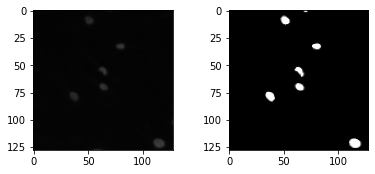

In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    c = tf.keras.activations.relu(c, alpha=0.0, max_value=None, threshold=0) +  tf.keras.activations.softsign(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(c)
    c = tf.keras.activations.relu(c, alpha=0.0, max_value=None, threshold=0) +  tf.keras.activations.softsign(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(concat)
    c = tf.keras.activations.relu(c, alpha=0.0, max_value=None, threshold=0) +  tf.keras.activations.softsign(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(c)
    c = tf.keras.activations.relu(c, alpha=0.0, max_value=None, threshold=0) +  tf.keras.activations.softsign(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    c = tf.keras.activations.relu(c, alpha=0.0, max_value=None, threshold=0) +  tf.keras.activations.softsign(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(c)
    c = tf.keras.activations.relu(c, alpha=0.0, max_value=None, threshold=0) +  tf.keras.activations.softsign(c)
    return c

In [7]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
   
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (2, 2), padding="same",  activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Tanh (TensorFlowOpL [(None, 128, 128, 16 0           conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Relu (

In [9]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history_relu4 = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/25
81/81 [==============================] - 17s 210ms/step - loss: 0.4437 - acc: 0.8358 - val_loss: 0.4247 - val_acc: 0.8185
Epoch 2/25
81/81 [==============================] - 6s 79ms/step - loss: 0.4147 - acc: 0.8588 - val_loss: 0.2822 - val_acc: 0.8580
Epoch 3/25
81/81 [==============================] - 6s 73ms/step - loss: 0.2556 - acc: 0.8792 - val_loss: 0.0918 - val_acc: 0.9500
Epoch 4/25
81/81 [==============================] - 6s 75ms/step - loss: 0.2051 - acc: 0.9005 - val_loss: 0.0929 - val_acc: 0.9474
Epoch 5/25
81/81 [==============================] - 6s 70ms/step - loss: 0.1943 - acc: 0.9059 - val_loss: 0.1009 - val_acc: 0.9430
Epoch 6/25
81/81 [==============================] - 6s 80ms/step - loss: 0.1834 - acc: 0.9147 - val_loss: 0.0748 - val_acc: 0.9546
Epoch 7/25
81/81 [==============================] - 6s 72ms/step - loss: 0.1728 - acc: 0.9152 - val_loss: 0.0930 - val_acc: 0.9469
Epoch 8/25
81/81 [==============================] - 6s 76ms/step - loss: 0.1448 -

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


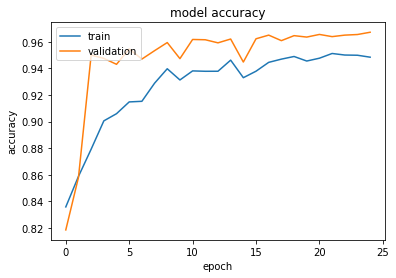

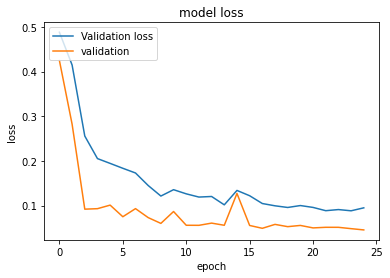

In [11]:
print(history_relu4.history.keys())
#  "Accuracy"
plt.plot(history_relu4.history['acc'])
plt.plot(history_relu4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history_relu4.history['loss'])
plt.plot(history_relu4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Validation loss', 'validation'], loc='upper left')
plt.show()

In [12]:
## Save the Weights
model.save_weights("UNtW.hmax")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

0.8677740863787375
0.9292066880113838
0.13222591362126246


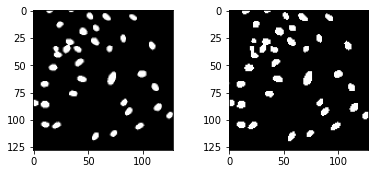

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)

ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")
y_pred=np.reshape(result[1]*255, (image_size, image_size))
y_true=np.reshape(y[1]*255, (image_size, image_size))
intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
mean, std_1 = cv2.meanStdDev(y_pred, y_true)
print(iou_score) 
img1 = np.asarray(y_true).astype(np.bool)
img2 = np.asarray(y_pred).astype(np.bool)
if img1.sum() + img2.sum() == 0:
    print(1) 
intersection = np.logical_and(img1, img2)
print(2. * intersection.sum() / (img1.sum() + img2.sum()))
intersection=abs(intersection)
union=abs(union)
voe=1-(intersection.sum()/union.sum())
print(voe)

0.7977594339622641
0.8875040997048212
0.20224056603773588


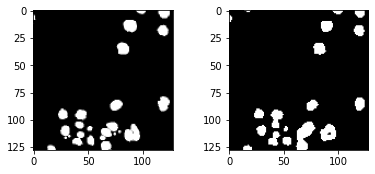

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

y_pred=np.reshape(result[0]*255, (image_size, image_size))
y_true=np.reshape(y[0]*255, (image_size, image_size))
intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
mean, std_1 = cv2.meanStdDev(y_pred, y_true)
print(iou_score) 
img1 = np.asarray(y_true).astype(np.bool)
img2 = np.asarray(y_pred).astype(np.bool)
if img1.sum() + img2.sum() == 0:
    print(1) 
intersection = np.logical_and(img1, img2)
print(2. * intersection.sum() / (img1.sum() + img2.sum()))
intersection=abs(intersection)
union=abs(union)
voe=1-(intersection.sum()/union.sum())
print(voe)